# Analysis of Bayesian optimization process
*Note*: In the following I made some changes in the code that I used for training the main model. For example, I changed the default params, or I reduced the total number of evaluations in the bayesian optimization in order to save time for finding optimal hyperparameters.

## load data

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def dir_id(directory: str) -> int:
    return {'anger': 0,
            'contempt': 1,
            'disgust': 2,
            'fear': 3,
            'happy': 4,
            'sadness': 5,
            'surprise': 6
            }[directory]


def preprocess_image(img_path: str, width: int, height: int) -> np.ndarray:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (width, height))
    img = np.array(img)
    img = img.reshape((1,) + img.shape)

    return img


def load_data(data: str, width: int, height: int) -> (np.ndarray, np.ndarray):
    """
    Assuming all pictures are structured in subdirectories names as the corresponding expression
    :param data: str containing the root directory of the data
    :param width: goal width of image
    :param height: goal height of image
    :return: tuple (evidence, labels)
    """
    evidence = []
    labels = []

    subdirectories = [directory for directory in os.listdir(data) if directory[0] != '.']

    for subdirectory in subdirectories:
        if os.path.isdir(os.path.join(data, subdirectory)):
            for img_path in os.listdir(os.path.join(data, subdirectory)):
                img = preprocess_image(os.path.join(data, subdirectory, img_path), width, height)
                evidence.append(img)
                labels.append(dir_id(subdirectory))

    return evidence, labels

## Create CNN based on hyperparameters

In [3]:
def create_model(width, height, categories,
                 num_convolutions, num_convolution_filters, pool_size, learning_rate,
                 num_dense_layers, num_dense_nodes, activation, dropout):
    """
    Returns a compiled CNN model
    hyperparameters:
    num_convolutions:           number of convolutional layers
    num_convolution_filters:    number of convolutional filters per convolutional layer
    pool_size:                  pool size for pooling layers
    learning_rate:              Learning-rate for the optimizer
    number_dense_layers:        Number of dense layers
    number_dense_nodes:         Number of nodes in each dense layer
    activation:                 Activation function for all layers
    dropout:                    Dropout
    """

    # Start construction of a Keras Sequential model
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Input(shape=(width, height, 1)))

    # convolutional layers and pooling with the respective sizes
    for i in range(num_convolutions):
        model.add(tf.keras.layers.Conv2D(kernel_size=5, strides=1, filters=num_convolution_filters, padding='same',
                                              activation=activation, name=f'layer_conv{i}'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), strides=2))

    # flatten out the data
    model.add(tf.keras.layers.Flatten())

    # fully-connected / dense layers.
    for i in range(num_dense_layers):
        model.add(tf.keras.layers.Dense(num_dense_nodes, activation=activation))

    # Add dropout to prevent over fitting
    model.add(tf.keras.layers.Dropout(rate=dropout))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification
    model.add(tf.keras.layers.Dense(units=categories, activation='softmax'))

    # Use the Adam method for training the network
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )

    return model

## Bayesian optimization

In [7]:
# Define fix parameters
DATA = '../CK+48'
TEST_SIZE = 0.3
IMG_WIDTH = 48
IMG_HEIGHT = 48
EPOCHS = 10
CATEGORIES = 7
BEST_MODEL_PATH = 'current_best_model.keras'

Define the search space that our bayesian optimization algorithm shall search on

In [8]:
# define search space
dim_num_convolutions = Integer(low=0, high=4, name='num_convolutions')
dim_num_convolution_filters = Integer(low=4, high=64, name='num_convolution_filters')
dim_pool_size = Integer(low=2, high=6, name='pool_size')
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_number_dense_layers = Integer(low=1, high=5, name='number_dense_layers')
dim_number_dense_nodes = Integer(low=5, high=1024, name='number_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'], name='activation')
dim_dropout = Real(low=0, high=0.99, prior='uniform', name='dropout')

dimensions = [
    dim_num_convolutions,
    dim_num_convolution_filters,
    dim_pool_size,
    dim_learning_rate,
    dim_number_dense_layers,
    dim_number_dense_nodes,
    dim_activation,
    dim_dropout
]

Now we define some default parameters, this is the starting point of the bayesian optimization.
Best accuracy will keep track of our current best accuracy and thus the best model we want to store.
Then we load the data and split it into train and test set.

In [9]:
default_params = [1, 32, 2, 1e-5, 1, 512, 'relu', 0.5]

best_accuracy = 0.0

# load data
evidence, labels = load_data(DATA, IMG_WIDTH, IMG_HEIGHT)

labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(np.array(evidence), np.array(labels), test_size=TEST_SIZE)

Now we define an evaluate function. It creates the model, augments the data, trains and evaluates the model on the test set and then returns the weighted accuracy of test and train accuracy to prevent overfitting on one of the test sets.

In [10]:
@use_named_args(dimensions)
def evaluate(num_convolutions, num_convolution_filters, pool_size, learning_rate, number_dense_layers,
             number_dense_nodes, activation, dropout) -> float:
    """
    hyperparameters:
    num_convolutions:           number of convolutional layers
    num_convolution_filters:    number of convolutional filters per convolutional layer
    pool_size:                  pool size for pooling layers
    learning_rate:              Learning-rate for the optimizer
    number_dense_layers:        Number of dense layers
    number_dense_nodes:         Number of nodes in each dense layer
    activation:                 Activation function for all layers
    dropout:                    Dropout
    """

    # Print the hyperparameters.
    print('num_convolutions: ', num_convolutions)
    print('num_convolution_filters: ', num_convolution_filters)
    print('pool_size: ', pool_size)
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', number_dense_layers)
    print('num_dense_nodes:', number_dense_nodes)
    print('activation:', activation)
    print('dropout:', dropout)
    print()

    # case that pooling would reduce the image to negative dimensions producing an error
    if min(IMG_WIDTH, IMG_HEIGHT) / (pool_size ** num_convolutions) < 1:
        return 1

    # Create the neural network with these hyperparameters.
    model = create_model(width=IMG_WIDTH,
                         height=IMG_HEIGHT,
                         categories=CATEGORIES,
                         num_convolutions=num_convolutions,
                         num_convolution_filters=num_convolution_filters,
                         pool_size=pool_size,
                         learning_rate=learning_rate,
                         num_dense_layers=number_dense_layers,
                         num_dense_nodes=number_dense_nodes,
                         activation=activation,
                         dropout=dropout)

    # data augmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255,
        brightness_range=[0.8, 1.2],
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        fill_mode='nearest',
        horizontal_flip=True
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

    global x_train
    global x_test

    # Reshape images for compatibility with the augmentation
    x_train = x_train.reshape((-1, IMG_WIDTH, IMG_HEIGHT, 1))
    x_test = x_test.reshape((-1, IMG_WIDTH, IMG_HEIGHT, 1))

    train_generator = train_datagen.flow(
        x_train,
        y_train,
        batch_size=32,
    )

    test_generator = test_datagen.flow(
        x_test,
        y_test,
        batch_size=32,
    )

    # train model and extract accuracy
    trained = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=test_generator
    )

    trained_accuracy = trained.history['val_accuracy'][-1]
    tested_accuracy = model.evaluate(test_generator)[1]

    # calculated weighted average of tested and trained accuracy to prevent overfitting of the bayesian
    # optimization on one of the test sets
    accuracy = (3*tested_accuracy + trained_accuracy) / 4

    # print the classification accuracy
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # update the best accuracy
    global best_accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save(BEST_MODEL_PATH)

    del model

    return 1 - accuracy

Now all that is left to do is to use scikit's gp_minimize function, which uses gaussian processes for minimizing the evaluate function, thus maximizing accuracy.

In [11]:
def optimize():
    """
    Performs bayesian optimization
    """
    result = gp_minimize(func=evaluate,
                         dimensions=dimensions,
                         acq_func='EI',
                         n_calls=40,
                         x0=default_params)

    return result

In [12]:
res = optimize()

num_convolutions:  1
num_convolution_filters:  32
pool_size:  2
learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 512
activation: relu
dropout: 0.5

Epoch 1/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.3125 - loss: 1.9224

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2150 - loss: 1.9182 - val_accuracy: 0.2746 - val_loss: 1.7810
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2656 - loss: 1.8156 - val_accuracy: 0.3898 - val_loss: 1.7688
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2758 - loss: 1.8146 - val_accuracy: 0.3898 - val_loss: 1.7316
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3178 - loss: 1.7884 - val_accuracy: 0.4915 - val_loss: 1.7335
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3292 - loss: 1.7468 - val_accuracy: 0.4949 - val_loss: 1.6944
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3382 - loss: 1.7607 - val_accuracy: 0.5119 - val_loss: 1.7049
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3674 - loss: 1.7543 - val_accuracy: 0.5085 - val_loss: 1.6321
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4344 - loss: 1.7001 - val_accuracy: 0.5051 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2181 - loss: 1.9634 - val_accuracy: 0.2983 - val_loss: 1.8999
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2053 - loss: 1.9838 - val_accuracy: 0.2915 - val_loss: 1.8933
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2379 - loss: 1.9820 - val_accuracy: 0.3017 - val_loss: 1.9051
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2634 - loss: 1.9559 - val_accuracy: 0.3051 - val_loss: 1.9029
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2599 - loss: 1.9375 - val_accuracy: 0.3119 - val_loss: 1.8887
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2656 - loss: 1.9409 - val_accuracy: 0.3153 - val_loss: 1.8885
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2324 - loss: 1.9515 - val_accuracy: 0.3085 - val_loss: 1.8983
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2804 - loss: 1.9616 - val_accuracy: 0.3220 - val_loss: 1.8753
Ep

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.1766 - loss: 4.4413 - val_accuracy: 0.2746 - val_loss: 1.9264
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.1971 - loss: 3.4875 - val_accuracy: 0.1424 - val_loss: 2.0376
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.1499 - loss: 3.4046 - val_accuracy: 0.2746 - val_loss: 1.8897
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.2025 - loss: 2.9206 - val_accuracy: 0.2746 - val_loss: 1.9360
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.2022 - loss: 2.9252 - val_accuracy: 0.2237 - val_loss: 1.9007
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.1792 - loss: 2.7918 - val_accuracy: 0.1424 - val_loss: 2.0251
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.1661 - loss: 2.7460 - val_accuracy: 0.1525 - val_loss: 2.0627
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.2016 - loss: 2.6858 - val_accuracy: 0.2746 - val_

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1579 - loss: 5.2566 - val_accuracy: 0.1424 - val_loss: 2.1334
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1787 - loss: 5.3418 - val_accuracy: 0.1424 - val_loss: 2.1546
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1674 - loss: 5.2574 - val_accuracy: 0.1424 - val_loss: 2.0828
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1587 - loss: 5.5958 - val_accuracy: 0.1424 - val_loss: 2.0953
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1763 - loss: 5.3137 - val_accuracy: 0.1424 - val_loss: 2.0575
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1844 - loss: 4.9429 - val_accuracy: 0.1424 - val_loss: 2.0637
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1700 - loss: 4.8214 - val_accuracy: 0.1424 - val_loss: 2.0433
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1767 - loss: 4.7469 - val_accuracy: 0.1424 - val_loss: 2.0230
E

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.1756 - loss: 1.9383 - val_accuracy: 0.2746 - val_loss: 1.7946
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2517 - loss: 1.8206 - val_accuracy: 0.2746 - val_loss: 1.7106
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2863 - loss: 1.7220 - val_accuracy: 0.4780 - val_loss: 1.2929
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.4431 - loss: 1.3679 - val_accuracy: 0.6034 - val_loss: 0.9686
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6022 - loss: 1.0332 - val_accuracy: 0.7559 - val_loss: 0.7133
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6382 - loss: 0.9300 - val_accuracy: 0.7356 - val_loss: 0.6388
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6241 - loss: 0.9563 - val_accuracy: 0.8102 - val_loss: 0.4893
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6990 - loss: 0.7963 - val_accuracy: 0.8305 - val_loss: 0

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.1167 - loss: 1.9435 - val_accuracy: 0.2407 - val_loss: 1.9327
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.1443 - loss: 1.9363 - val_accuracy: 0.2610 - val_loss: 1.9280
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.1731 - loss: 1.9395 - val_accuracy: 0.3288 - val_loss: 1.9252
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1581 - loss: 1.9279 - val_accuracy: 0.3831 - val_loss: 1.9167
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.2425 - loss: 1.9205 - val_accuracy: 0.3356 - val_loss: 1.9124
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.1995 - loss: 1.9210 - val_accuracy: 0.3322 - val_loss: 1.9144
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.2299 - loss: 1.9204 - val_accuracy: 0.3322 - val_loss: 1.9064
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.2234 - loss: 1.9114 - val_accuracy: 0.4203 - val_

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1782 - loss: 2.4057 - val_accuracy: 0.2746 - val_loss: 1.8609
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2428 - loss: 1.8406 - val_accuracy: 0.2746 - val_loss: 1.7813
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2723 - loss: 1.8088 - val_accuracy: 0.2305 - val_loss: 1.7661
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2472 - loss: 1.7657 - val_accuracy: 0.3831 - val_loss: 1.4897
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3705 - loss: 1.5871 - val_accuracy: 0.5525 - val_loss: 1.2524
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5046 - loss: 1.3214 - val_accuracy: 0.5898 - val_loss: 1.1907
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5660 - loss: 1.1709 - val_accuracy: 0.6576 - val_loss: 0.8324
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5630 - loss: 1.0994 - val_accuracy: 0.4814 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2159 - loss: 1.9375 - val_accuracy: 0.2271 - val_loss: 1.8968
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2497 - loss: 1.9050 - val_accuracy: 0.2746 - val_loss: 1.8664
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2693 - loss: 1.8752 - val_accuracy: 0.2746 - val_loss: 1.8487
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2236 - loss: 1.8947 - val_accuracy: 0.2746 - val_loss: 1.8648
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2270 - loss: 1.8882 - val_accuracy: 0.2746 - val_loss: 1.8428
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2467 - loss: 1.8830 - val_accuracy: 0.2746 - val_loss: 1.8359
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2508 - loss: 1.8767 - val_accuracy: 0.2746 - val_loss: 1.8229
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2423 - loss: 1.8782 - val_accuracy: 0.2746 - val_loss: 1.8394
Ep

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2067 - loss: 1.9475 - val_accuracy: 0.1831 - val_loss: 1.8071
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2453 - loss: 1.8777 - val_accuracy: 0.2746 - val_loss: 1.8138
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2474 - loss: 1.8323 - val_accuracy: 0.3288 - val_loss: 1.7492
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2845 - loss: 1.7886 - val_accuracy: 0.4746 - val_loss: 1.5319
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3812 - loss: 1.6426 - val_accuracy: 0.4814 - val_loss: 1.2620
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4580 - loss: 1.3166 - val_accuracy: 0.5729 - val_loss: 1.0681
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5333 - loss: 1.1951 - val_accuracy: 0.6678 - val_loss: 0.8455
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5859 - loss: 1.0714 - val_accuracy: 0.6373 - val_loss: 0.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1983 - loss: 1.9468 - val_accuracy: 0.2237 - val_loss: 1.9425
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2151 - loss: 1.9413 - val_accuracy: 0.2237 - val_loss: 1.9347
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1866 - loss: 1.9392 - val_accuracy: 0.2237 - val_loss: 1.9324
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2140 - loss: 1.9323 - val_accuracy: 0.2237 - val_loss: 1.9226
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2220 - loss: 1.9338 - val_accuracy: 0.2237 - val_loss: 1.9209
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2203 - loss: 1.9298 - val_accuracy: 0.2237 - val_loss: 1.9199
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2001 - loss: 1.9419 - val_accuracy: 0.2237 - val_loss: 1.9237
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2195 - loss: 1.9258 - val_accuracy: 0.2237 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2411 - loss: 2.3724 - val_accuracy: 0.2746 - val_loss: 1.7849
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3152 - loss: 1.7961 - val_accuracy: 0.3729 - val_loss: 1.7002
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3635 - loss: 1.6348 - val_accuracy: 0.4847 - val_loss: 1.3603
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4564 - loss: 1.4266 - val_accuracy: 0.3797 - val_loss: 1.4767
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4562 - loss: 1.4117 - val_accuracy: 0.5220 - val_loss: 1.1594
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4375 - loss: 1.4300 - val_accuracy: 0.4169 - val_loss: 1.2372
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4682 - loss: 1.2906 - val_accuracy: 0.5051 - val_loss: 1.2086
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4489 - loss: 1.3196 - val_accuracy: 0.5220 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1776 - loss: 6.9661 - val_accuracy: 0.3424 - val_loss: 1.8693
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1902 - loss: 3.9784 - val_accuracy: 0.2814 - val_loss: 1.8672
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1830 - loss: 2.2757 - val_accuracy: 0.2881 - val_loss: 1.9090
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2340 - loss: 2.0550 - val_accuracy: 0.2136 - val_loss: 1.9255
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2513 - loss: 2.0068 - val_accuracy: 0.2237 - val_loss: 1.9470
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2733 - loss: 1.9884 - val_accuracy: 0.2814 - val_loss: 1.9317
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2131 - loss: 1.9432 - val_accuracy: 0.1627 - val_loss: 1.9680
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2475 - loss: 1.9977 - val_accuracy: 0.2746 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1291 - loss: 2.5109 - val_accuracy: 0.2746 - val_loss: 1.8188
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1905 - loss: 1.8913 - val_accuracy: 0.2746 - val_loss: 1.7918
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2316 - loss: 1.8639 - val_accuracy: 0.2746 - val_loss: 1.7220
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2255 - loss: 1.8129 - val_accuracy: 0.2746 - val_loss: 1.4756
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3033 - loss: 1.7851 - val_accuracy: 0.4542 - val_loss: 1.4957
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3905 - loss: 1.5695 - val_accuracy: 0.3831 - val_loss: 1.3406
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3634 - loss: 1.5739 - val_accuracy: 0.4847 - val_loss: 1.2801
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4131 - loss: 1.4421 - val_accuracy: 0.4881 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.1677 - loss: 21.0663 - val_accuracy: 0.2746 - val_loss: 1.8129
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2400 - loss: 1.8495 - val_accuracy: 0.2780 - val_loss: 1.7408
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2144 - loss: 1.7792 - val_accuracy: 0.3288 - val_loss: 1.5586
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2528 - loss: 1.8545 - val_accuracy: 0.1288 - val_loss: 1.7932
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2331 - loss: 1.7971 - val_accuracy: 0.2746 - val_loss: 1.7165
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2386 - loss: 1.7681 - val_accuracy: 0.3559 - val_loss: 1.5356
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3353 - loss: 1.6686 - val_accuracy: 0.4678 - val_loss: 1.3261
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3698 - loss: 1.4760 - val_accuracy: 0.4068 - val_loss: 1

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1762 - loss: 4.1962 - val_accuracy: 0.2746 - val_loss: 1.8295
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2239 - loss: 1.8712 - val_accuracy: 0.2881 - val_loss: 1.7760
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2478 - loss: 1.8529 - val_accuracy: 0.3017 - val_loss: 1.7839
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2876 - loss: 1.7829 - val_accuracy: 0.3966 - val_loss: 1.5768
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3725 - loss: 1.6247 - val_accuracy: 0.4780 - val_loss: 1.5313
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4265 - loss: 1.4428 - val_accuracy: 0.4780 - val_loss: 1.2519
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4469 - loss: 1.3897 - val_accuracy: 0.4780 - val_loss: 1.2614
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4431 - loss: 1.3765 - val_accuracy: 0.3831 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.1828 - loss: 1.9313 - val_accuracy: 0.2780 - val_loss: 1.8253
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.1948 - loss: 1.8698 - val_accuracy: 0.2746 - val_loss: 1.7908
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.2315 - loss: 1.8670 - val_accuracy: 0.2746 - val_loss: 1.7757
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.2466 - loss: 1.8426 - val_accuracy: 0.4237 - val_loss: 1.6966
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.3001 - loss: 1.7913 - val_accuracy: 0.5390 - val_loss: 1.5747
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4136 - loss: 1.6338 - val_accuracy: 0.5729 - val_loss: 1.3338
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.4352 - loss: 1.4620 - val_accuracy: 0.4847 - val_loss: 1.1703
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.4601 - loss: 1.3835 - val_accuracy: 0.4949 - val_

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2047 - loss: 2.0112 - val_accuracy: 0.2746 - val_loss: 1.8078
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2477 - loss: 1.8926 - val_accuracy: 0.2949 - val_loss: 1.7742
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2368 - loss: 1.8494 - val_accuracy: 0.3288 - val_loss: 1.7222
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2976 - loss: 1.7939 - val_accuracy: 0.4271 - val_loss: 1.5827
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3657 - loss: 1.7039 - val_accuracy: 0.5356 - val_loss: 1.3765
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4274 - loss: 1.5207 - val_accuracy: 0.5186 - val_loss: 1.2676
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4531 - loss: 1.4147 - val_accuracy: 0.5559 - val_loss: 1.1923
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4380 - loss: 1.4329 - val_accuracy: 0.6102 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.2054 - loss: 3.0904 - val_accuracy: 0.1525 - val_loss: 1.8844
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1896 - loss: 2.8512 - val_accuracy: 0.2237 - val_loss: 1.8006
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1994 - loss: 2.5066 - val_accuracy: 0.2746 - val_loss: 1.8540
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.1896 - loss: 2.2108 - val_accuracy: 0.2746 - val_loss: 1.8368
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1664 - loss: 2.0981 - val_accuracy: 0.2237 - val_loss: 1.8320
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2403 - loss: 1.9511 - val_accuracy: 0.2746 - val_loss: 1.8278
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2190 - loss: 1.9256 - val_accuracy: 0.2237 - val_loss: 1.8088
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.2290 - loss: 1.8936 - val_accuracy: 0.2746 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.2148 - loss: 1.8906 - val_accuracy: 0.4610 - val_loss: 1.7455
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3404 - loss: 1.7682 - val_accuracy: 0.4780 - val_loss: 1.5315
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4178 - loss: 1.5205 - val_accuracy: 0.5288 - val_loss: 1.2144
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.4629 - loss: 1.3588 - val_accuracy: 0.6203 - val_loss: 1.1050
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5591 - loss: 1.1981 - val_accuracy: 0.6678 - val_loss: 0.8583
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5919 - loss: 1.0356 - val_accuracy: 0.6847 - val_loss: 0.7731
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6699 - loss: 0.9134 - val_accuracy: 0.6814 - val_loss: 0.7136
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6839 - loss: 0.7927 - val_accuracy: 0.7186 - val_loss: 0

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2560 - loss: 1.8744 - val_accuracy: 0.3966 - val_loss: 1.6960
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4347 - loss: 1.6442 - val_accuracy: 0.5085 - val_loss: 1.3513
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4754 - loss: 1.4299 - val_accuracy: 0.6102 - val_loss: 1.0723
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5438 - loss: 1.2638 - val_accuracy: 0.6441 - val_loss: 0.9364
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5546 - loss: 1.1795 - val_accuracy: 0.6305 - val_loss: 1.0303
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5911 - loss: 1.1140 - val_accuracy: 0.6881 - val_loss: 0.8316
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6388 - loss: 1.0498 - val_accuracy: 0.6508 - val_loss: 0.8727
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6232 - loss: 0.9895 - val_accuracy: 0.6983 - val_loss: 0.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1904 - loss: 20.3043 - val_accuracy: 0.2305 - val_loss: 1.8148
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2094 - loss: 1.8626 - val_accuracy: 0.2746 - val_loss: 1.9575
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2504 - loss: 1.8650 - val_accuracy: 0.2746 - val_loss: 1.8119
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2487 - loss: 1.8530 - val_accuracy: 0.2780 - val_loss: 1.8305
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2425 - loss: 1.8933 - val_accuracy: 0.2508 - val_loss: 1.8269
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2221 - loss: 1.8684 - val_accuracy: 0.2034 - val_loss: 1.8619
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2338 - loss: 2.0297 - val_accuracy: 0.2475 - val_loss: 1.8212
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2491 - loss: 1.8374 - val_accuracy: 0.2746 - val_loss: 1.8034

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1851 - loss: 1.8793 - val_accuracy: 0.2746 - val_loss: 1.7787
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2609 - loss: 1.8196 - val_accuracy: 0.4203 - val_loss: 1.6923
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4243 - loss: 1.6396 - val_accuracy: 0.4610 - val_loss: 1.3771
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4842 - loss: 1.4124 - val_accuracy: 0.6305 - val_loss: 1.0174
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5853 - loss: 1.1105 - val_accuracy: 0.6508 - val_loss: 0.8245
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6217 - loss: 0.9808 - val_accuracy: 0.6407 - val_loss: 0.8842
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6329 - loss: 1.0084 - val_accuracy: 0.6814 - val_loss: 0.7231
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6879 - loss: 0.8172 - val_accuracy: 0.7288 - val_loss: 0.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2044 - loss: 1.8759 - val_accuracy: 0.2746 - val_loss: 1.7948
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2395 - loss: 1.8348 - val_accuracy: 0.4407 - val_loss: 1.7310
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3634 - loss: 1.6944 - val_accuracy: 0.5017 - val_loss: 1.2689
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4955 - loss: 1.2853 - val_accuracy: 0.6508 - val_loss: 1.0625
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5776 - loss: 1.1104 - val_accuracy: 0.5966 - val_loss: 0.9647
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5981 - loss: 0.9663 - val_accuracy: 0.6712 - val_loss: 0.8195
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6442 - loss: 0.9355 - val_accuracy: 0.7051 - val_loss: 0.8488
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6753 - loss: 0.7753 - val_accuracy: 0.7729 - val_loss: 0.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1890 - loss: 1.9222 - val_accuracy: 0.2746 - val_loss: 1.8505
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2190 - loss: 1.8618 - val_accuracy: 0.2746 - val_loss: 1.8346
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2264 - loss: 1.8718 - val_accuracy: 0.2746 - val_loss: 1.8429
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2398 - loss: 1.8313 - val_accuracy: 0.2746 - val_loss: 1.8423
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2460 - loss: 1.8441 - val_accuracy: 0.2746 - val_loss: 1.8168
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2197 - loss: 1.8301 - val_accuracy: 0.2746 - val_loss: 1.7931
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2327 - loss: 1.8300 - val_accuracy: 0.2746 - val_loss: 1.8010
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2628 - loss: 1.8289 - val_accuracy: 0.2746 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.2023 - loss: 1.8874 - val_accuracy: 0.4712 - val_loss: 1.7709
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3690 - loss: 1.7475 - val_accuracy: 0.4712 - val_loss: 1.4426
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.4631 - loss: 1.4054 - val_accuracy: 0.5695 - val_loss: 1.0674
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5366 - loss: 1.1648 - val_accuracy: 0.6576 - val_loss: 0.9194
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6344 - loss: 0.9323 - val_accuracy: 0.7288 - val_loss: 0.6408
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6687 - loss: 0.8105 - val_accuracy: 0.8237 - val_loss: 0.5190
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7407 - loss: 0.6656 - val_accuracy: 0.8271 - val_loss: 0.4272
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7930 - loss: 0.5632 - val_accuracy: 0.8780 - val_

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.2294 - loss: 1.8733 - val_accuracy: 0.4644 - val_loss: 1.6823
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.3558 - loss: 1.6758 - val_accuracy: 0.5661 - val_loss: 1.2274
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.4847 - loss: 1.3652 - val_accuracy: 0.6475 - val_loss: 0.9440
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6356 - loss: 0.9759 - val_accuracy: 0.6780 - val_loss: 0.6711
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7203 - loss: 0.7575 - val_accuracy: 0.7661 - val_loss: 0.5602
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7356 - loss: 0.6837 - val_accuracy: 0.8475 - val_loss: 0.5282
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7912 - loss: 0.5777 - val_accuracy: 0.7593 - val_loss: 0.6517
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7916 - loss: 0.5557 - val_accuracy: 0.8542 - val_

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1697 - loss: 2.2359 - val_accuracy: 0.2746 - val_loss: 1.8158
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1662 - loss: 1.9593 - val_accuracy: 0.2746 - val_loss: 1.8109
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2119 - loss: 1.9451 - val_accuracy: 0.2746 - val_loss: 1.7958
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1874 - loss: 1.9136 - val_accuracy: 0.3017 - val_loss: 1.8089
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2146 - loss: 1.8997 - val_accuracy: 0.2949 - val_loss: 1.7705
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2827 - loss: 1.8058 - val_accuracy: 0.4271 - val_loss: 1.6584
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3100 - loss: 1.7069 - val_accuracy: 0.4441 - val_loss: 1.4398
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3921 - loss: 1.5875 - val_accuracy: 0.4678 - val_loss: 1.

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.2091 - loss: 1.9225 - val_accuracy: 0.2237 - val_loss: 1.8033
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.3187 - loss: 1.7407 - val_accuracy: 0.4881 - val_loss: 1.2994
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4428 - loss: 1.3189 - val_accuracy: 0.5797 - val_loss: 1.0950
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5353 - loss: 1.1765 - val_accuracy: 0.6915 - val_loss: 0.7028
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5772 - loss: 1.0195 - val_accuracy: 0.7525 - val_loss: 0.6433
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.6712 - loss: 0.7622 - val_accuracy: 0.7288 - val_loss: 0.6075
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7428 - loss: 0.6890 - val_accuracy: 0.7966 - val_loss: 0.4976
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7502 - loss: 0.6932 - val_accuracy: 0.7932 - val_loss

/Users/lukasschaller/Documents/Programmieren/2024/ML-Learning/FacialExpressionRecognition/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2453 - loss: 1.8610 - val_accuracy: 0.3627 - val_loss: 1.7177
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3433 - loss: 1.7369 - val_accuracy: 0.4915 - val_loss: 1.3611
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4600 - loss: 1.4045 - val_accuracy: 0.5763 - val_loss: 1.0722
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5561 - loss: 1.1520 - val_accuracy: 0.6407 - val_loss: 0.9950
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5196 - loss: 1.1930 - val_accuracy: 0.7186 - val_loss: 0.8310
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5976 - loss: 1.0573 - val_accuracy: 0.5695 - val_loss: 1.1213
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5628 - loss: 1.0247 - val_accuracy: 0.7288 - val_loss: 0.7550
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6832 - loss: 0.8188 - val_accuracy: 0.7424 - val_loss: 0.

# Analysis

In [16]:
# optimal hyperparameters found
print(f"{res.x} lead to a objective function value of {res.fun}")

[1, 64, 2, 0.0002990459768613554, 5, 927, 'relu', 0.020538264207905825] lead to a objective function value of 0.10169494152069092


<Axes: >

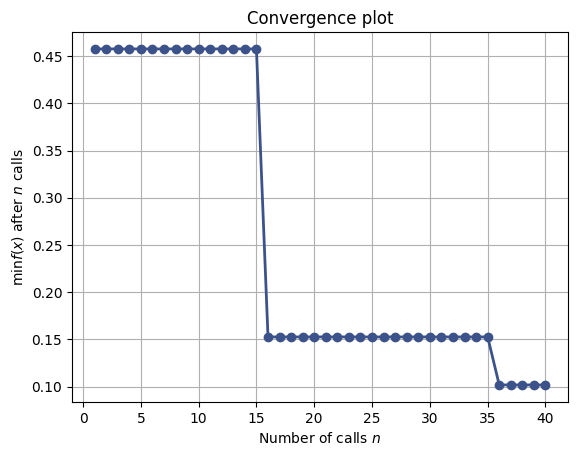

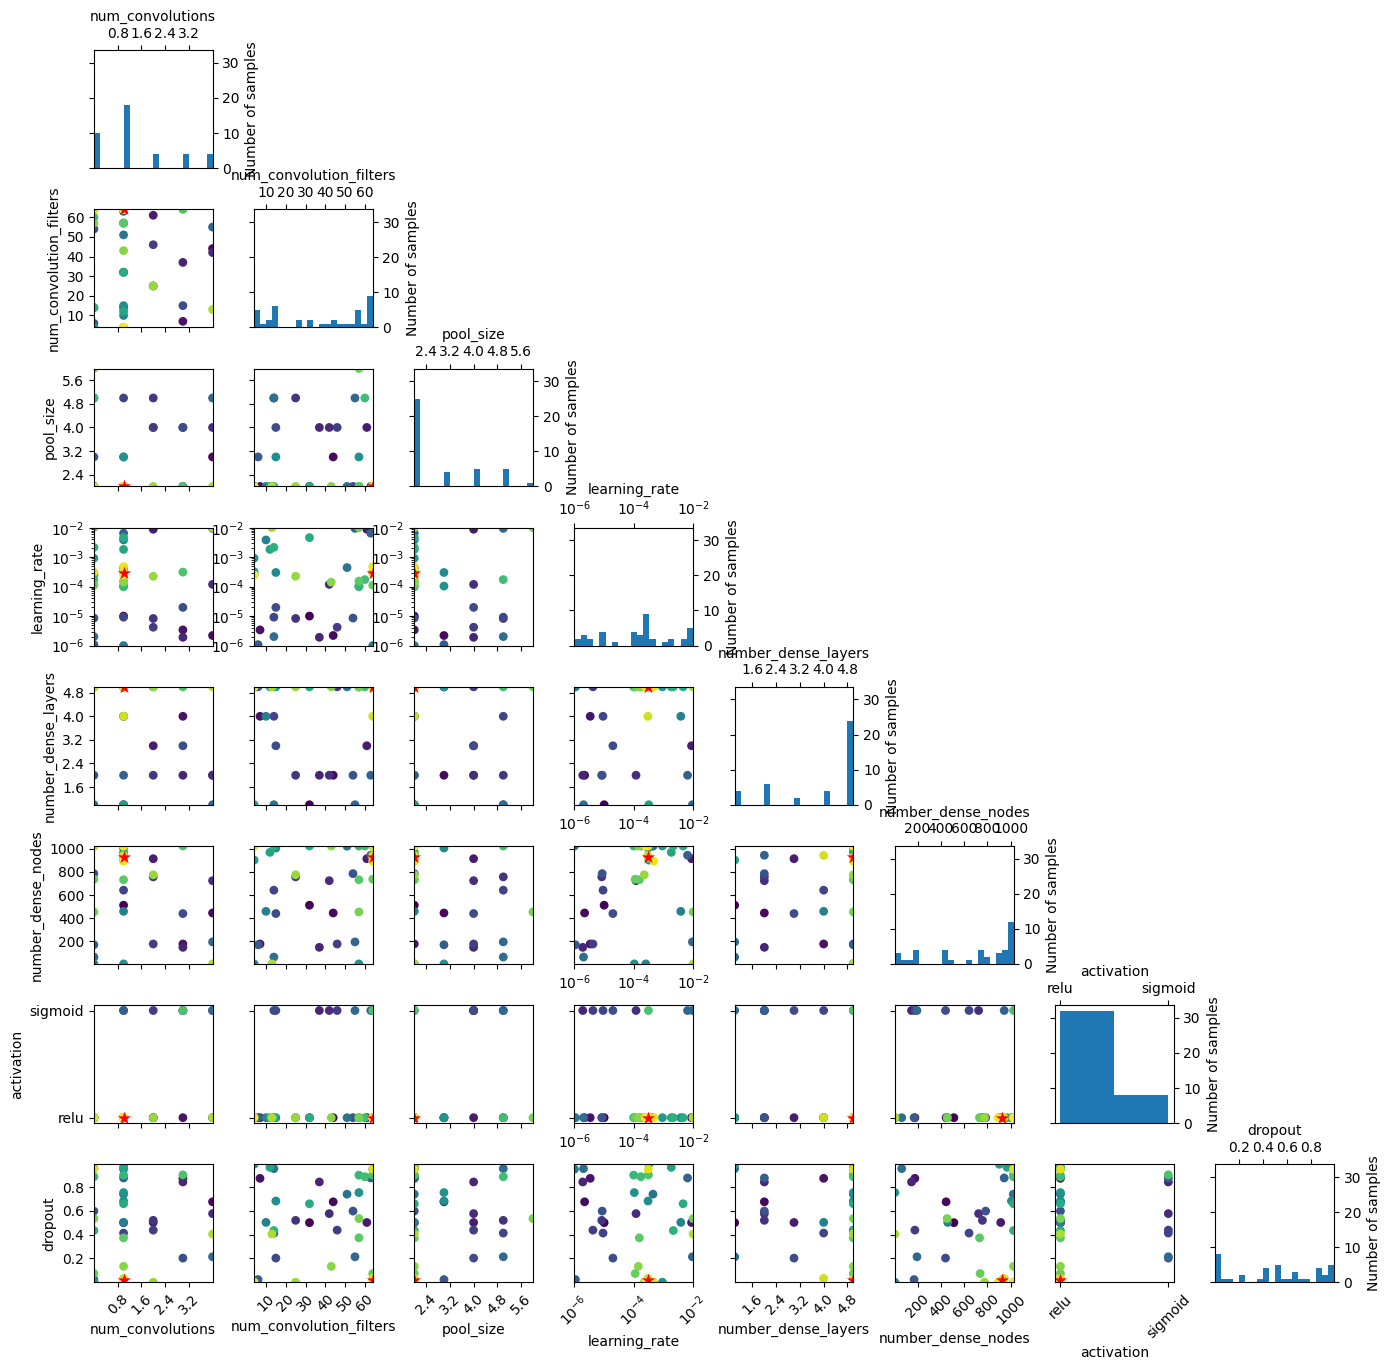

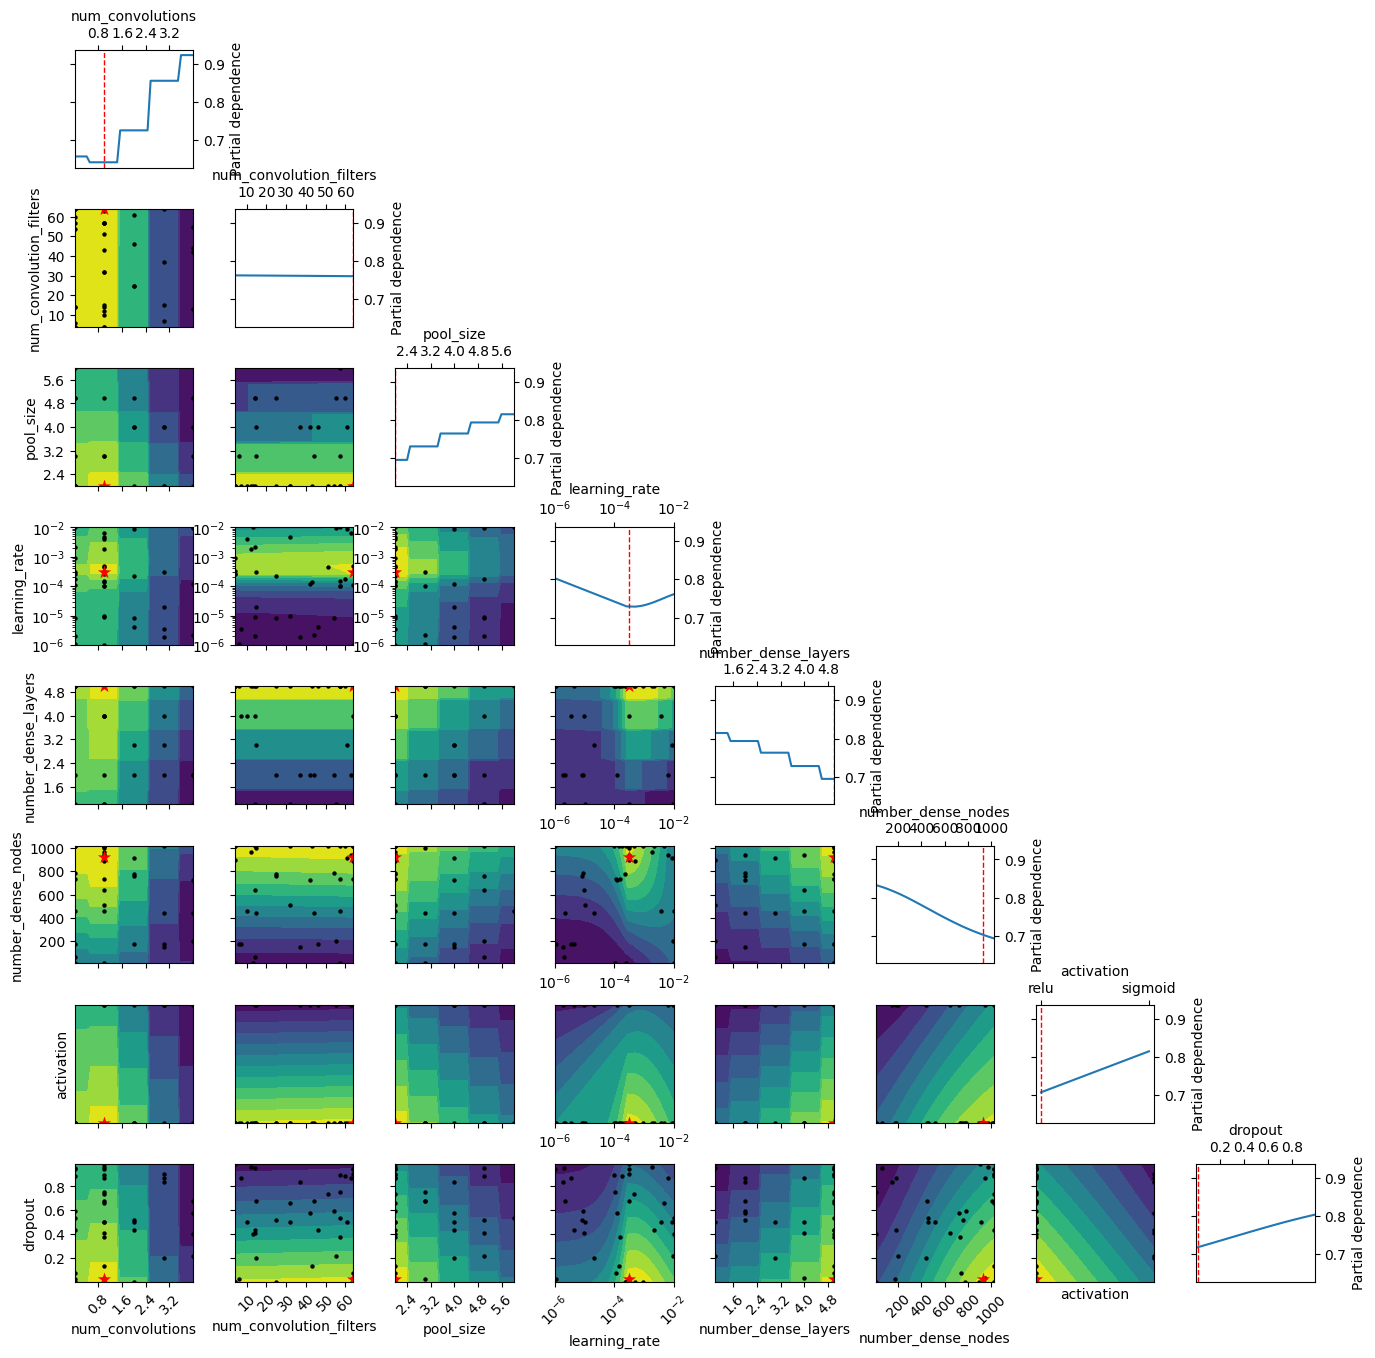

In [14]:
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

# *note*: the following plots may take a while to render

# plots how the minimum of the objective function converged to the end result
plot_convergence(res)

# shows when in the search process which (combinations of) dimensions where evaluated
plot_evaluations(res)

# shows partial dependencies of dimensions, i.e. the influence a certain hyperparameter has on the objective function
plot_objective(res)